Snippets:
* `(pyvenv)> python3 -m pip freeze > reqs.txt` - wyeksportuj bib pyvenv'a
* `(pyvenv)> python3 -m pip install -r reqs.txt` - zaktualizuj biblioteki pyvenv'a

Utils

In [1]:
## CODE
import datetime

ceil = lambda x: int(x + (x!=int(x)))

timestamp = lambda: datetime.datetime.now().strftime("%Y%m%dT%H%M%S")

In [2]:
## PARAMS

clf_dir = "./clf_pickles/"

=== DATA READ ===

LOAD `((c x *.jpg; c x *.csv[label_x_ref,*labels_cls]) -> (dx, dy, dl))`

> Wczytaj i zwaliduj dane wejściowe (%walidacje wypisane #komach)

params:
* `data_x_target_shape: (image_res_X, image_res_Y, Channels)`   - standaryzacja obrazów
* `label_x_ref`           - kolumna w pandas'ie z hashami do obrazów
* `labels_cls`            - kolumny w pandas'ie z kategoriami klasyfikacji

args:
* `data_x_path_regex`     - regex do plików z input'em (obrazów)
* `data_y_path_regex`     - regex do csv-ek z output'em (ground of truth), load merguje je ze sobą

output:
* ~~`dx: {dy[label_x_ref]: ndarray[c, *data_x_target_shape]]}` - słownik z obrazami hashowany `label_x_ref`~~ (tylko dla walidacji poprawności)
* `dy: pandas.dataframe[label_x_ref,*labels_cls, ...]` - ... (wszystko do uczenia powinno tu być, kategorie w każdej formie)
* ~~`dl: Tuple[string]` -  lista kategorii po filtracji~~

In [3]:
## PARAMS
data_x_target_shape = (600, 450, 3)
label_x_ref = 'image'
# labels_cls = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']  # klasyfikacja kategoryczna pełna
labels_cls = ['NV', 'BKL']  # klasyfikacja (de-facto) binarna

In [4]:
## CODE
import glob
# import cv2
import pandas as pd
import numpy as np

label_x_path    = 'path'
label_y_sparse  = 'sparse'
label_y_cat     = 'categorical'

# preprocess X data
data_x_target_res = data_x_target_shape[:2]
# def data_x_loader(data_x_path):
#     x = data_x_path
#     x = cv2.imread(x)
#     x = cv2.resize(x, data_x_target_res)
#     x = cv2.cvtColor(x, cv2.COLOR_BGR2YCrCb)
#     return x

def load(data_x_path_regex, data_y_path_regex):
    # read & merge Y data
    data_y_paths = glob.glob(data_y_path_regex)
    print("CSV found:")
    for data_y_path in data_y_paths:
        print(f"    {data_y_path}") 

    assert data_y_paths.__len__() > 0
    dy_full = pd.concat([pd.read_csv(data_y_path) for data_y_path in data_y_paths])

    # todo: filter out nulls
    dy = dy_full

    # filter out samples & labels of fewer than 2 positive
    labels_cls_too_few = dy[labels_cls].loc[:, (dy[labels_cls].sum() < 2)].columns
    for label_cls_too_few in labels_cls_too_few:
        dy = dy.drop(dy[dy.loc[:, label_cls_too_few] == 1].index, axis=0)
    dy = dy.drop(labels_cls_too_few, axis=1)
    dl = [label_cls for label_cls in labels_cls if label_cls not in labels_cls_too_few]

    # read & filter_out by Y & map X data
    data_x_paths = glob.glob(data_x_path_regex)
    data_x_paths = [dxp.replace('\\', '/') for dxp in data_x_paths]
    map_ref2path_full = {ref: next((dxp for dxp in data_x_paths if ref in dxp), None) for ref in dy_full[label_x_ref]}
    map_ref2path = {ref: data_x_path for ref, data_x_path in map_ref2path_full.items() if (ref == dy[label_x_ref]).any() and data_x_path is not None}
    # dx = {ref: data_x_loader(data_x_path) for ref, data_x_path in map_ref2path.items()}

    # filter out Y entries that dont have X entry
    dy = dy.loc[dy[label_x_ref].isin(map_ref2path.keys())]

    # add path column
    paths = [map_ref2path[ref] for ref in dy[label_x_ref]]
    dy[label_x_path] = paths

    # add sparse & categorical classification column
    dy[label_y_sparse] = dy[dl].to_numpy().argmax(axis=1)
    dy[label_y_cat] = [dl[y_spar] for y_spar in dy[label_y_sparse]]

    print(
    f"""Read stats:
    # entries ok: {dy.__len__()}
    # excess X: {map_ref2path_full.__len__() - map_ref2path.__len__()}
    # excess Y: {dy_full.__len__() - dy.__len__()}
    # excess L: {labels_cls_too_few.__len__()}  """) # e.L- Labels of too little samples

    print("# samples/label:")
    print(dy[dl].sum(axis=0).astype(int), end="\t\n")
    return None, dy, dl

In [5]:
## PLAYGROUND
data_x_path_regex = r"../ISIC2018_Task3_Training_Input/*.jpg"
data_y_path_regex = r"../ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv"
## używałem tylko https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip ~KS 20230603

_, dy, _ = load(data_x_path_regex, data_y_path_regex)
dl = labels_cls
dy

CSV found:
    ../ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
Read stats:
    # entries ok: 10015
    # excess X: 0
    # excess Y: 0
    # excess L: 0  
# samples/label:
NV     6705
BKL    1099
dtype: int32	


,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,path,sparse,categorical
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,../ISIC2018_Task3_Training_Input/ISIC_0024306.jpg,0,NV
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,../ISIC2018_Task3_Training_Input/ISIC_0024307.jpg,0,NV
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,../ISIC2018_Task3_Training_Input/ISIC_0024308.jpg,0,NV
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,../ISIC2018_Task3_Training_Input/ISIC_0024309.jpg,0,NV
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,../ISIC2018_Task3_Training_Input/ISIC_0024310.jpg,0,NV
...,...,...,...,...,...,...,...,...,...,...,...
10010,ISIC_0034316,1.0,0.0,0.0,0.0,0.0,0.0,0.0,../ISIC2018_Task3_Training_Input/ISIC_0034316.jpg,0,NV
10011,ISIC_0034317,1.0,0.0,0.0,0.0,0.0,0.0,0.0,../ISIC2018_Task3_Training_Input/ISIC_0034317.jpg,0,NV
10012,ISIC_0034318,0.0,0.0,0.0,0.0,1.0,0.0,0.0,../ISIC2018_Task3_Training_Input/ISIC_0034318.jpg,1,BKL
10013,ISIC_0034319,0.0,1.0,0.0,0.0,0.0,0.0,0.0,../ISIC2018_Task3_Training_Input/ISIC_0034319.jpg,0,NV


In [6]:
## PLAYGROUND > CHECK IF TF ON GPU
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

from keras import backend
print(backend._get_available_gpus())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
['/device:GPU:0']


In [7]:
## PLAYGROUND > CHECK IF CUPY ON GPU
import cupy as cp

cp.zeros((1,)).device

<CUDA Device 0>

=== PREPROCESING ===

...

%at least atm - todo?: zaimportować jak w isic'u

params:
* `batch_size: int` - wspólne dla wszystkich generatorów i klasyfikatorów
* `tts_factor: float in (0, 1)` - train-test split factor
* `train_datagen: keras.preprocessing.image.ImageDataGenerator` - ustawienia augmentacji danych

input:
* `dy: pandas.dataframe[label_x_ref,*labels_cls, ...]`

output:
* `train_generator: keras.preprocessing.image.DataFrameIterator`
* `test_generator:  keras.preprocessing.image.DataFrameIterator`
* ...


In [8]:
## CODE
def label_stratifier(dyi, spc):
    """ duplicate samples in dataframe until desired # (=spc) of each category reached"""
    dyo = pd.concat([dupl[:(spc-(dx*ldupl))] 
        for cat in dl  
        for dupl, ldupl in ((dyi[dyi[cat] == 1.0], len(dyi[dyi[cat] == 1.0])),)
        for dx in range(ceil(spc/ldupl))
    ])
    dyo = dyo.sample(frac=1)  # shuffle

    dy_info = pd.concat([
        dyi[dl].sum(axis=0).astype(int).rename("was"), 
        dyo[dl].sum(axis=0).astype(int).rename("is")], axis=1)
    return dyo, dy_info 


In [9]:
## PARAMS
from keras.preprocessing import image

batch_size = 16
tts_factor = .2
train_datagen = image.ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
)

In [10]:
## PLAYGROUND
from sklearn.model_selection import train_test_split

dyt1, dys1 = train_test_split(dy, test_size=tts_factor, stratify=dy[dl].to_numpy().argmax(axis=1), shuffle=True, )

dyt, dyt_info = label_stratifier(dyt1, 3000)
print("Training dataset: \n", dyt_info)

dys = dys1
print("Training dataset: \n", dys[dl].sum(axis=0).astype(int))

train_datagen = train_datagen
train_generator = train_datagen.flow_from_dataframe(
      dataframe=dyt,
      directory=".",
      x_col=label_x_path,
      y_col=dl,
      # subset="training",
      batch_size=batch_size,
      # seed=42,
      shuffle=True,
      class_mode="raw",
      target_size=data_x_target_res,
)

smol_generator = train_datagen.flow_from_dataframe(  # for end-of-samples testing 
      dataframe=dyt[:int(batch_size*1.5)],
      directory=".",
      x_col=label_x_path,
      y_col=dl,
      # subset="training",
      batch_size=batch_size,
      # seed=42,
      shuffle=True,
      class_mode="raw",
      target_size=data_x_target_res,
)

val_generator = None  # jebać, za mało sampli, crossvalidation 4ever

test_datagen = image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
      dataframe=dys,
      directory=".",
      x_col=label_x_path,
      y_col=dl,
      # subset="validation",
      batch_size=batch_size,
      # seed=42,
      shuffle=False,
      class_mode="raw",
      target_size=data_x_target_res,
)

dummy_test_datagen = test_datagen
dummy_test_generator = dummy_test_datagen.flow_from_dataframe(  # dane treningowe bez powtarzania, augmentacji i shuffle 
      dataframe=dyt1,
      directory=".",
      x_col=label_x_path,
      y_col=dl,
      # subset="validation",
      batch_size=batch_size,
      # seed=42,
      shuffle=False,
      class_mode="raw",
      target_size=data_x_target_res,
) 
# bez shuffle bo nie da się (chyba) inaczej odtworzyć która próbka jest która z samego generatora (zob. gen2ojala -> filenames)


Training dataset: 
       was    is
NV   5379  3000
BKL   879  3000
Training dataset: 
 NV     1326
BKL     220
dtype: int32
Found 6000 validated image filenames.
Found 24 validated image filenames.
Found 2003 validated image filenames.
Found 8012 validated image filenames.


=== METRCS ===

SUMUP

> Wygeneruj podsumowanie klasyfikacji testowej

%jak coś jeszcze się przyda to dodawać

params:
* \-

args:
* `y_got, y_pred: np.ndarray[Samples, Labels] || np.ndarray[Samples] || List[Label_str]` - klasyfikacje odpowiednio: ground-of-truth, przewidywane 
* `references: Optional[List[Any]]` - dane do identyfikacji próbek, za porządkiem `y_got`, `y_pred`
* `labels: Optional[List]` - wektor kategorii

output:
* `juxta: pd.DataFrame[reference, ...]` - lista porównań wyniku klasyfikacji w odniesieniu do referencji
* `confusion_mx_sample: NestedLists[Labels Labels]` - macierz pomyłek względem liczby sampli w porządku `[y_got, y_pred]`
* `confusion_mx_percent: NestedLists[Labels Labels]` - macierz pomyłek względem % sampli danych `y_got`
* `references_mx: NestedLists[Labels, Labels, X* str]]` - macierz listy referencji do próbek w danej komórce macierzy pomyłek
* `labels: List[str || int]` - wektor kategorii (generyczny jeśli nie podano w args)


In [11]:
## CODE
from sklearn.metrics import confusion_matrix

juxta_col_reference = "reference"
juxta_col_cat = ["GoT", "predicted"]
juxta_col_sparse = ["#GoT", "#predicted"]

def sumup(y_got, y_pred, references=None, labels=None):
    ## convert y_got, y_pred to sparse
    if type(y_got[0]) == str:  # categorical
        dl = labels or list(set(y_got).union(list(y_pred)))
        y_got = np.asarray([dl.index(y_s) for y_s in y_got])
        y_pred = np.asarray([dl.index(y_s) for y_s in y_pred])
    elif np.asarray(y_got).shape.__len__() == 1:  # sparse
        dl = labels or list(set(y_got).union(list(y_pred)))
    elif np.asarray(y_got).shape.__len__() == 2:  # full
        dl = labels or np.arange(y_got[0].__len__())
        y_got = y_got.argmax(axis=1)
        y_pred = y_pred.argmax(axis=1)
    references = references or ["?"] *y_got.__len__()

    juxta = pd.DataFrame(zip(
            references, 
            [dl[catix] for catix in y_got], 
            [dl[catix] for catix in y_pred],
            y_got,
            y_pred,
        ), columns=[juxta_col_reference, *juxta_col_cat, *juxta_col_sparse])

    confusion_mx_sample  = confusion_matrix(y_got, y_pred, sample_weight=None).astype(int)
    
    # weights by y_got
    sample_weight = [(1/(y_got == catix).sum()) for catix in range(dl.__len__())]
    sample_weight = np.asarray([sample_weight[catix] for catix in y_got]) *100
    confusion_mx_percent = confusion_matrix(y_got, y_pred, sample_weight=sample_weight).astype(int)

    references_mx = [[juxta.loc[np.logical_and(
            juxta[juxta_col_sparse[0]] == catix_got,
            juxta[juxta_col_sparse[1]] == catix_pred
        ), juxta_col_reference].tolist() 
        for catix_pred in range(dl.__len__())] for catix_got in range(dl.__len__())]
    
    return juxta, confusion_mx_sample, confusion_mx_percent, references_mx, labels


=== DTC OJALA ===

GEN2OJALA
> Przetwórz dane generatora na wektor parametrów LBP_ui2 + VAR (Ojala et.al., 2002)

% można jeszcze spróbować z konwersją obrazu jakby się komuś nudziło ale powinno być git atm

% nie zmieniać mi tego kurwa ~KS

params:
* \-

args:
* `generator_raw: keras.preprocessing.image.DataFrameIterator -> np.ndarray[Batch_size, image_res_Y, image_res_X, Channels]` - generator danych
* `rbp_l: [N_rpb* (Radius_i: int, Points_i: int, Bins_i: int)]` - parametry: `radius` - promień sąsiedztwa LBP, `Points` - liczba pnktów sąsiedztwa LBP, `Bins` - liczba elementów histogramu LBP/VAR
* `no_batches: int = None` - liczba batch'ów do wygenerowania

output:
* `ojala_x: np.ndarray[Samples, Channel* (N_rbp* (2**Points_i+Bins_i))]` - macierz zlinearyzowanych wektorów parametrów
* `ojala_y: np.ndarray[Samples, Labels]` - macierz kategorii klasyfikacji
* `filepaths: Optional[None, List[str]]` - jeśli `generator_raw.shuffle == True`: lista nazw plików `dy["path"]` za porządkiem `ojala_x`, `ojala_y` 

In [12]:
## CODE
from tqdm import tqdm
import numpy as np
import cupy as cp
# from numba import jit
import cv2

# def alloc_test(n, dtype, module=np):
#     print(f"""U are safe to allocate {
#         module.zeros((int(n),), dtype=dtype).ravel().size *8/1024**3
#         } GB of RAM""")

def quick_hist(*args, **kwargs):
    hi = cp.histogram(*args, **kwargs)[0] 
    return hi / hi.sum(axis=-1)

def rpb2lbp_consts(image_res, rbp):
    # print(rbp) #dg
    np = cp
    r, p, b = rbp

    adj_domain = np.linspace(0, 2*np.pi, p, endpoint=False)
    adj_weights = np.power(2, np.arange(p))

    vert_adj = ((r+1-1e-6)* np.sin(adj_domain)).astype(int)
    hori_adj = ((r+1-1e-6)* np.cos(adj_domain)).astype(int)
    # plt.plot(hori_adj, vert_adj, marker='o')

    vert_centres, hori_centres, _ = np.mgrid[r:image_res[0]-r, r:image_res[1]-r, 0:1]
    vert_cadj = vert_centres + vert_adj
    hori_cadj = hori_centres + hori_adj

    ld = ud = np.arange(2**p, dtype=np.uint32)
    ud_circled = ud + np.bitwise_and(ud, 1)*(2**p)
    ud_binary = np.bitwise_xor(ud_circled, ud_circled >>1)

    ud_merged = np.zeros(2**p, dtype=np.uint8)
    ld_merged = np.zeros(2**p, dtype=np.uint8)
    step = int((2**p)/p)

    for sx in range(0, 2**p, step): # P=24 raised oom here with 4GB VRAM before merged ver
        # lookup condition
        ud_expo = (np.bitwise_and(ud_binary[sx:sx+step, None], (2**np.arange(p)))) #.astype(np.uint32)#.sum(axis=1)
        # print(ud_expo.size) #dg
        ud_sumup = (ud_expo != 0).astype(np.uint32)
        ud_sumup = ud_sumup[..., None].sum(axis=-2).squeeze()
        ud_merged[sx:sx+step] = ud_sumup

        # lookup value
        ld_expo = (np.bitwise_and(ld[sx:sx+step, None], (2**np.arange(p))))
        ld_sumup = (ld_expo != 0).astype(np.uint32)  
        ld_sumup = ld_sumup[..., None].sum(axis=-2).squeeze()
        ld_merged[sx:sx+step] = ld_sumup

    lookup = np.where(ud_merged <= 2, ld_merged, p+1)  # Ojala, 2002, (9, 10)

    return (vert_centres, hori_centres, vert_cadj, hori_cadj, 
            adj_weights, lookup,
            p, b)

def lbp_var(image_batch, lbp_consts):
    vert_centres, hori_centres, vert_cadj, hori_cadj, adj_weights, lookup, p, b = lbp_consts

    mx_cadj = image_batch[..., vert_cadj, hori_cadj]
    mx_centres = image_batch[..., vert_centres, hori_centres]

    lbp_idx_raster_l = ((mx_cadj <= mx_centres) * adj_weights)
    lbp_idx_raster_wa = lbp_idx_raster_l[..., None].sum(-2).squeeze()  # (w)ork(a)round for cupy bug
    lbp_idx_lin = lbp_idx_raster_wa.reshape((*image_batch.shape[:-2], -1))
    lbp_lin = lookup[lbp_idx_lin]
    hi_lbp = cp.apply_along_axis(quick_hist, -1, lbp_lin, bins=(p+2), range=(0, p+2))

    var_raster_l = cp.power(mx_cadj - mx_cadj[..., None].mean(axis=-2), 2)
    var_raster_wa = var_raster_l[..., None].sum(-2).squeeze()  # Ojala, 2002, (11)
    var_log_lin = cp.log1p(var_raster_wa.reshape((*image_batch.shape[:-2], -1)))
    hi_var = cp.apply_along_axis(quick_hist, -1, var_log_lin, b, range=None)

    return hi_lbp, hi_var

def gen2ojala(generator_raw, rpb_l, no_batches=None):
    no_batches = min(no_batches, generator_raw.__len__()) if no_batches else generator_raw.__len__()
    test_batch_x = generator_raw[0][0]
    batch_size = test_batch_x.__len__()
    data_x_target_res = test_batch_x.shape[-3:-1]
    no_samples = batch_size*(no_batches-1) + generator_raw[no_batches-1][0].__len__()
    no_params = 3*np.sum([(p+2)+b for _, p, b in rpb_l])

    ojala_x = np.zeros((no_samples, no_params), dtype=np.float64) # dtype default for np division
    ojala_y = np.zeros((no_samples, labels_cls.__len__()), dtype=np.float64)
    # print(batch_size,(no_batches-1) , generator_raw[no_batches-1].__len__())

    lbp_consts_l = [rpb2lbp_consts(data_x_target_res, rpb) for rpb in rpb_l]

    for batch_ix in tqdm(range(no_batches)):
    # for batch_ix in range(no_batches):
        batch_x, batch_y = generator_raw[batch_ix]
        ojala_y[batch_ix*batch_size:(batch_ix+1)*batch_size] = batch_y

        oxb = []
        batch_x = cp.asarray(batch_x)
        # batch_x = cp.asarray([cv2.cvtColor(im, cv2.COLOR_RGB2HSV_FULL) for im in batch_x])
        batch_x = cp.moveaxis(batch_x, 3, 1)  # (Sample_ix, Channel, Y, X)
        for lc in lbp_consts_l:
            lbp_res, var_res = lbp_var(batch_x, lc)
            oxb.append(cp.asnumpy(lbp_res))  # (RBP_conf, S, C, H)
            oxb.append(cp.asnumpy(var_res))  # (RBP_conf, S, C, H)
            # print('i', lbp_res.shape) #dg
        
        lbp_merged = oxb
        lbp_merged = np.concatenate(lbp_merged, axis=-1) # concat lbp + var and reduce RBP_conf dim
        lbp_merged = lbp_merged.reshape((*batch_x.shape[:-3], -1)) # reduce Channel dim 
        # print('m', lbp_merged.shape, batch_x.shape, (*batch_x.shape[:-2], -1)) #dg
        ojala_x[batch_ix*batch_size:(batch_ix+1)*batch_size, :] = lbp_merged  # (S, C*R*H)

    filenames = None if generator_raw.shuffle else generator_raw.filenames[:(no_batches*batch_size)]

    return ojala_x, ojala_y, filenames


In [13]:
## PLAYGROUND > GENERATE TRAIN DATA

# [(radius, n_points, var_bins)] list
# rpb_l= ((1, 8, 16), (3, 16, 32), (5, 24, 32), (8, 16, 64))
rpb_l= ((1, 8, 16), (2, 16, 16), (3, 16, 16))

ojala_tx, ojala_ty, _ = gen2ojala(train_generator, rpb_l, no_batches=5)

# ojala_xx, ojala_xy = gen2ojala(smol_generator, rpb_l, no_batches=None)
# ojala_xx.shape

100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


In [14]:
## PLAYGROUND > LEARN [& SAVE?] MODEL
from sklearn.tree import DecisionTreeClassifier
# import pickle

ojala_clf_label = "ojala"

dtc_ojala = DecisionTreeClassifier()
dtc_ojala.fit(np.random.random((3, 3)), [4,5,6])
dtc_ojala.fit(ojala_tx, ojala_ty) # 5.5min with 131 params x 1800 samples

# with open(clf_dir + ojala_clf_label + '_' + timestamp() + '.pkl', 'wb') as f:
#     pickle.dump(dtc_ojala, f)

# with open('ojala1.pkl', 'rb') as f:
#     dtc_ojala = pickle.load(f)

DecisionTreeClassifier()

In [15]:
## PLAYGROUND > EVALUATE MODEL
ojala_sx, ojala_sy, filenames = gen2ojala(dummy_test_generator, rpb_l, 5)

ojala_py = dtc_ojala.predict(ojala_sx)

sumup(ojala_sy, ojala_py, references=filenames, labels=dl)

100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


(                                            reference  GoT predicted  #GoT  \
 0   ../ISIC2018_Task3_Training_Input/ISIC_0030793.jpg   NV        NV     0   
 1   ../ISIC2018_Task3_Training_Input/ISIC_0033018.jpg   NV       BKL     0   
 2   ../ISIC2018_Task3_Training_Input/ISIC_0033473.jpg   NV        NV     0   
 3   ../ISIC2018_Task3_Training_Input/ISIC_0027474.jpg   NV        NV     0   
 4   ../ISIC2018_Task3_Training_Input/ISIC_0027194.jpg  BKL        NV     1   
 ..                                                ...  ...       ...   ...   
 75  ../ISIC2018_Task3_Training_Input/ISIC_0033418.jpg   NV       BKL     0   
 76  ../ISIC2018_Task3_Training_Input/ISIC_0034116.jpg   NV       BKL     0   
 77  ../ISIC2018_Task3_Training_Input/ISIC_0032087.jpg   NV       BKL     0   
 78  ../ISIC2018_Task3_Training_Input/ISIC_0026808.jpg   NV       BKL     0   
 79  ../ISIC2018_Task3_Training_Input/ISIC_0029800.jpg   NV       BKL     0   
 
     #predicted  
 0            0  
 1            

=== CNN ===

%src: ex s9/DNN/lab4
% coś slabo mi się uczy ale pewnie danych mao - nie dotyczy atm :)

params:
* ~~`batch_size`~~ - (chyba) musi się zgrać z datagen
* `model....`
* `model.fit(...)`
* `flatten_res_max` - do jakiego rozmiaru `H*W` konwolucja ma zredukować obraz (żeby nie narobiło parametrów)

args:
* `(train_generator, `~~`validation_generator`~~`)` - zostawiamy crossvalidation

output:
* `model: ?` 
* `history: keras.callbacks.History`

In [9]:
## PLAYGROUND > CREATE MODEL
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

# batch_size = 16
flatten_res_max = 200  

model = models.Sequential()
model.add(layers.Rescaling(1./255, 0., input_shape=data_x_target_shape)) # %todo: remove rescaling factor with new training

conv_converg  = lambda cr: (((cr[0]-2) // 2), (cr[1]-2)//2)
step_channels = 1
conv_redo = data_x_target_res
while (conv_redo := conv_converg(conv_redo)) and conv_redo[0]*conv_redo[1] > flatten_res_max:
    step_channels += 1

for n_channels in np.linspace(16, 64, step_channels, endpoint=True):
    model.add(layers.Conv2D(n_channels, (3,)*2, activation='relu'))
    model.add(layers.MaxPooling2D((2,)*2))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(dl), activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 600, 450, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 598, 448, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 299, 224, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 297, 222, 28)      4060      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 148, 111, 28)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 146, 109, 40)      1

In [11]:
## PLAYGROUND > TRAIN
history = model.fit(
    train_generator,
    steps_per_epoch=30,
    epochs=5,
    # validation_data=val_generator,
    # augment=True, #? https://stackoverflow.com/questions/57092637 - chuja tam, ale nieszkodzi, augmentuje się z generatora
    #   validation_steps=len(val_flow)
) #verbose=2)

Epoch 1/5
30/30 [==============================] - 69s 2s/step - loss: 1.9459 - accuracy: 0.1396
Epoch 2/5
30/30 [==============================] - 68s 2s/step - loss: 1.9462 - accuracy: 0.1448
Epoch 3/5
30/30 [==============================] - 65s 2s/step - loss: 1.9459 - accuracy: 0.1281
Epoch 4/5
30/30 [==============================] - 61s 2s/step - loss: 1.9461 - accuracy: 0.1510
Epoch 5/5
30/30 [==============================] - 60s 2s/step - loss: 1.9458 - accuracy: 0.1615


In [56]:
## PLAYGROUND > LOAD & SAVE MODEL %TBD
# from tensorflow.keras.models import load_model

# ! echo $(getFreeGPU)
# model.save("model1")
# train_generator[250][0].shape
# model = load_model('model1')

=== CNN ADDITIONAL METRICS === %TBD

% na razie zarzucam tę sekcję, bo w sumie nie wiadomo czy się przyda a mi było tylko potrzebne do ogarnięcia czy się uczy ~KS

In [57]:

# ohe.inverse_transform
# confusion_matrix(cdyv.argmax(axis=1), model.predict(cdxv.swapaxes(1,2)).argmax(axis=1))
# confusion_matrix(np.asarray(dyv).argmax(axis=1), model.predict(np.asarray(dxv)).argmax(axis=1))
# no_samples = 250

# for bx in range(ceil(val_generator.__len__()//batch_size)):
#     confusion_matrix
    
# np.sum([
#     print(confusion_matrix(byv.argmax(axis=1), model.predict(bxv).argmax(axis=1), labels=[x for x in range(dl.__len__())]))
#     # print(model.predict(bxv).shape)
#     for bix in range(val_generator.__len__()) for bxv, byv in (val_generator[bix],) 
# ], axis=0)

confusion_matrix(test_generator.labels.argmax(axis=1), model.predict(test_generator).argmax(axis=1))

63/63 [==============================] - 23s 362ms/step


array([[ 18, 149,  31,   0,  25,   0,   0],
       [107, 951, 163,   0, 120,   0,   0],
       [ 11,  65,  18,   0,   9,   0,   0],
       [  7,  44,   9,   0,   5,   0,   0],
       [ 26, 144,  27,   0,  23,   0,   0],
       [  3,  14,   5,   0,   1,   0,   0],
       [  4,  19,   4,   0,   1,   0,   0]], dtype=int64)

In [54]:
## draft
# for a in range(10):
#     print(model.predict(np.concatenate([val_generator[a][0], val_generator[a][0], val_generator[a][0], val_generator[a][0]], axis=0)).shape)
# np.asarray(dyv).shape
# for a in val_generator:
#     print(a[1].shape)
# a, b = [] * 2
# b.append(0)
# 2/3

# val_generator[62][0].shape
# confusion_matrix(val_generator.labels.argmax(axis=1), model.predict(val_generator).argmax(axis=1))
# confusion_matrix(val_generator.labels.argmax(axis=1), p.argmax(axis=1))
# model.predict(val_generator)
# val_generator.labels.shape
# p = model.predict(val_generator)
# print(p, p.shape, val_generator.labels, val_generator.labels.shape)

array([[   0,    0,    0,    0,    0,  223,    0],
       [   0,    0,    0,    0,    0, 1341,    0],
       [   0,    0,    0,    0,    0,  103,    0],
       [   0,    0,    0,    0,    0,   65,    0],
       [   0,    0,    0,    0,    0,  220,    0],
       [   0,    0,    0,    0,    0,   23,    0],
       [   0,    0,    0,    0,    0,   28,    0]], dtype=int64)

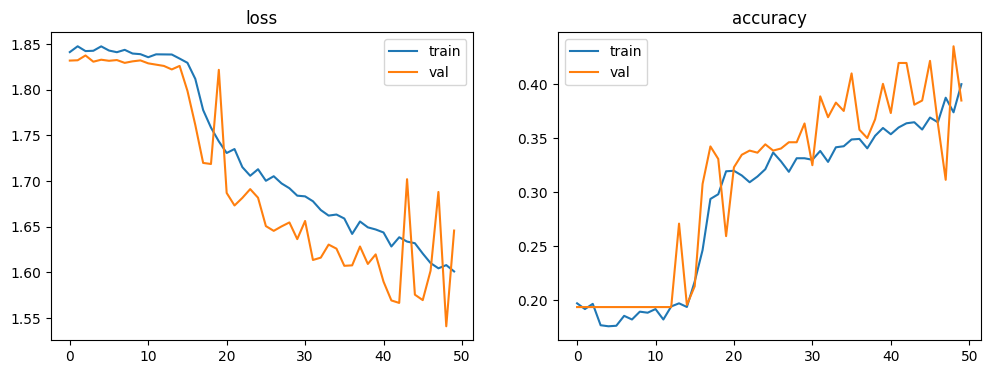

In [102]:
from matplotlib import pyplot as plt

# Porównanie metryk uczenia
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
h = history.history

ax[0].set_title('loss')
ax[0].plot(h['loss'], label='train')
ax[0].plot(h['val_loss'], label='val')
ax[0].legend()

ax[1].set_title('accuracy')
ax[1].plot(h['accuracy'], label='train')
ax[1].plot(h['val_accuracy'], label='val')
ax[1].legend()

DUMP

In [10]:
# g = train_datagen.flow_from_dataframe(
#       dataframe=dyt[:1],
#       directory=".",
#       x_col=label_x_path,
#       y_col=dl,
#       # subset="training",
#       batch_size=batch_size,
#       # seed=42,
#       shuffle=True,
#       class_mode="raw",
#       target_size=data_x_target_res,
# )

# for i in g:
#     print(g)

In [ ]:
## draft
# from sklearn.metrics import confusion_matrix

# doyp = dtc_ojala.predict(ojala_sx)

# confusion_matrix(ojala_sy.argmax(axis=1), doyp.argmax(axis=1), sample_weight=(100*ojala_sy/ojala_sy.sum(axis=0)).sum(axis=1)).astype(int)
# print("\n")
# print(f"Test labels #: {ojala_sy.sum(axis=0)}")


# import matplotlib.pyplot as plt

# plt.imshow(dummy_test_generator[0][0][0])
# dummy_test_generator[0][1]
# dyt[:16]
# dummy_test_gene/rator.shuffle
# (100*ojala_sy/ojala_sy.sum(axis=0)).sum(axis=1)
# ojala_sy.sum(axis=0)


# glob.glob(clf_dir + ojala_clf_label + "*")


In [9]:
# cp._default_memory_pool.
# cp._default_pinned_memory_pool.free_all_blocks()
# cp.get_default_memory_pool().free_all_blocks()
# cp.get_default_pinned_memory_pool().free_all_blocks()
# import gc
# gc.collect()

In [10]:
# draft

# np.random.random((1024, 1024)).astype(np.float32).sum()
# (ojala_sy/ojala_sy.sum(axis=0)).sum(axis=1).shape

# def ll(*x):
#     print('i', x)
#     return np.asarray([[[1,2], [3,4]]])
# rpb_l= ((1, 8, 64), (3, 16, 256), (5, 24, 704))

# # ll = lambda im: local_binary_pattern(im.reshape(data_x_target_shape)[..., 0], 8, 1)
# # ll = lambda im: local_binary_pattern(im[..., 0], 8, 1)
# # ll = lambda im: sample_raw2ojala(im[..., 0], rpb_l)
# def ll(im): 
#     print(im.shape)
#     sample_raw2ojala(im[..., :], rpb_l)

# ar = (np.random.random((64, *data_x_target_shape)) *255).astype(np.uint8)

# # r = np.apply_along_axis(ll, 1, ar.reshape((ar.shape[0], -1)))
# # r = [ll(ar[i]) for i in range(32)]
# print('a')
# with Pool(4) as pool:
#     r =  pool.map(ll, ar)
# print('b')
# # print('r', list(r))
# for a in r:
#     print(a)

# import tensorflow as tf

# # train_generator_raw.ma
# tf.data.Dataset.from_generator(train_generator_raw)

# ojala_tx.dump("ojala_tx.bak")
# ojala_ty.dump("ojala_ty.bak")

# e = [np.random.random((32, 3, 16)), np.random.random((32, 3, 16)), np.random.random((37, 3, 16))]
# np.concatenate(e, axis=0).shape

# e = np.concatenate(e, axis=2)
# # e = e.reshape((batch_size, -1))
# print(e.shape)
# e = np.concatenate(e, axis=0)

# e.shape
# ot.shape
# ot.reshape((3500, 32, 3, -1)).shape
# x = [[ot[s:(s+96)][t:(t+3)] for t in range(0, 96, 3)]  for s in range(0, 105000, 96)]
# print(np.asarray(x[0]).shape, len(x))
# print(np.asarray(x[0]).reshape((batch_size, -1)).shape)
# xx = np.concatenate([np.asarray(xb).reshape((batch_size, -1)) for xb in x[:1093]], axis=0)

# print(xx[0].shape, ojala_tx_[0].shape)
# print(xx[0])
# print(ojala_tx_[0])
# # print(ot.shape)
# print(ot.reshape((35000, 3, 144)).reshape((35000, -1))[0])

# a = np.arange(24).reshape((2,3,4))
# print(a)
# print(a.reshape((2, -1)))

# from tqdm import tqdm
# import numpy
# np = numpy
# import cupy as cp
# # import cv2

# e = cp.arange(24).reshape((2,3,4))
# # print(cp.sum(e, axis=2, keepdims=True).squeeze())
# print(e[..., None].sum(axis=-2).squeeze())

# def quick_hist(*args, **kwargs):
#     hi = np.histogram(*args, **kwargs)[0]
#     return hi / hi.sum(axis=-1)

# def rpb2lbp_consts(image_res, rbp):
#     np = cp
#     r, p, b = rbp

#     adj_domain = np.linspace(0, 2*np.pi, p, endpoint=False)
#     adj_weights = np.power(2, np.arange(p))

#     vert_adj = ((r+1-1e-6)* np.sin(adj_domain)).astype(int)
#     hori_adj = ((r+1-1e-6)* np.cos(adj_domain)).astype(int)
#     # plt.plot(hori_adj, vert_adj, marker='o')

#     vert_centres, hori_centres, _ = np.mgrid[r:image_res[0]-r, r:image_res[1]-r, 0:1]
#     vert_cadj = vert_centres + vert_adj
#     hori_cadj = hori_centres + hori_adj

#     return (vert_centres, hori_centres, vert_cadj, hori_cadj, adj_weights, p, b)

# def lbp(image_batch, lbp_consts):
#     print('chuj')
#     vert_centres, hori_centres, vert_cadj, hori_cadj, adj_weights, p, b = lbp_consts

#     mx_cadj = image_batch[..., vert_cadj, hori_cadj]
#     mx_centres = image_batch[..., vert_centres, hori_centres]
#     print('chuj2')
#     print(adj_weights.device)

#     mx_lbp_raster = ((mx_cadj <= mx_centres) * adj_weights) #.sum(axis=-1)
#     print('chuj3')
#     mx_lbp_lin = mx_lbp_raster.reshape((*image_batch.shape[:-2], -1))
#     print('chuj4')

#     hi = np.apply_along_axis(quick_hist, -1, mx_lbp_lin, bins=b, range=(0, 2**p))
#     print('dupa')
#     del mx_cadj, mx_centres, mx_lbp_raster, mx_lbp_lin
#     print('cipa')
#     return hi

# def gen2ojala(_, rpb_l, no_batches=None):
    # ojala_x, ojala_y = [], []
    # generator_raw = numpy.random.random((10, 32, 600, 450, 3))
    # np = cp

    # lbp_consts_l = [rpb2lbp_consts((600, 450), rpb) for rpb in rpb_l]

    # for batch_ix in tqdm(range(no_batches)):
    #     batch_x = generator_raw[batch_ix]
    #     # ojala_y.append(batch_y)

    #     oxb = []
    #     batch_x = np.asarray(batch_x)
    #     batch_x = np.moveaxis(batch_x, 3, 1)  # (Sample_ix, Channel, Y, X)
    #     print(batch_x.device)
    #     for lc in lbp_consts_l:
    #         lbp_res = lbp(batch_x, lc)
    #         print('i', lbp_res.shape) #dg
    #         oxb.append(lbp_res)  # (RBP_conf, S, C, H)
        
    #     lbp_merged = oxb
    #     lbp_merged = np.concatenate(lbp_merged, axis=-1) # reduce RBP_conf dim
    #     lbp_merged = lbp_merged.reshape((*batch_x.shape[:-2], -1)) # reduce Channel dim
    #     print('m', lbp_merged.shape) #dg
    #     ojala_x.append(lbp_merged)  # (S, C*R*H)

    # ojala_x = np.concatenate(ojala_x, axis=0)
    # # ojala_y = np.concatenate(ojala_y, axis=0)

    # return ojala_x, ojala_y

# rpb_l= ((1, 8, 16), (3, 16, 32))#, (5, 24, 32), (8, 24, 32))

# # ojala_tx, ojala_ty = gen2ojala(train_generator_raw, rpb_l, no_batches=2)
# ojala_tx, ojala_ty = gen2ojala(None, rpb_l, no_batches=2)
# print(ojala_tx.shape)

# alloc_test(1e40, np.float64, np)

In [11]:
# import matplotlib.pyplot as plt

# # ar = (np.random.random((4, 12, 12)) *255).astype(np.uint8)
# # ar = np.arange(4*10*10).reshape((4, 10, 10))
# ar = train_generator_raw[0][0][..., 0]
# # # print(ar[0])

# # r = 1
# # p = 8
# # b = 16
# # assert not (p%4)


# lc = rpb2lbp_consts(ar.shape[-2:], (8, 24, 64))

# lr = cp.asnumpy(lbp(cp.asarray(ar), lc))
# # lr.shape

# plt.plot(lr.T)


In [12]:
# def gen2ojala(generator_raw, rpb_l, no_batches=None):
#     # dtf nie wspiera batchowania (z tego co wyczytalem)
#     # generator_raw = train_generator_raw
#     ojala_x, ojala_y = [], []
#     no_batches = no_batches or min(no_batches, generator_raw.__len__())
#     for batch_ix in tqdm(range(no_batches)): #dg; quick check
#         # print("batch {}/{}".format(batch_ix, generator_raw.__len__()))
#         batch_x, batch_y = generator_raw[batch_ix]
#         # ojala_x.append([sample_raw2ojala(sample_x, rpb_l) for sample_x in batch_x])
#         # ojala_x.append(np.apply_along_axis(sample_raw2ojala, 1, batch_x.reshape(batch_x.shape[0], -1), rpb_l))
#         ojala_y.append(batch_y)

#         batch_x_merged = batch_x.reshape((batch_x.shape[0]*batch_x.shape[1], batch_x.shape[2], batch_x.shape[3]))
#         bm = batch_x_merged
#         bm = cv2.cvtColor(bm, cv2.COLOR_RGB2HSV)
#         bm = bm[..., 1]
#         bm = (bm *255).astype(np.uint8)

#         ravel = [[] for _ in range(batch_x.shape[0])]
#         for _, (radius, n_points, n_bins) in enumerate(rpb_l):
#             d = datetime.now()
#             bm_lbp = local_binary_pattern(bm, n_points, radius)
#             print( datetime.now() - d) #dg


#             for sx in range(batch_x.shape[0]):
#                 sample_lbp = bm_lbp[(sx*batch_x.shape[1]):((sx+1)*batch_x.shape[1])]
#                 hist = np.histogram(sample_lbp, n_bins, (0, 2**n_points))
#                 ravel[sx].extend(hist[0])
#         ojala_x.append(ravel)

#     ojala_x = np.concatenate(ojala_x, axis=0)
#     ojala_y = np.concatenate(ojala_y, axis=0)

#     return ojala_x, ojala_y

# [0, 1, 1, 3, 1, 5, 4, ]
# aw = np.power(2, np.arange(p+1))
# ae = np.power(2, np.arange(p+1)) - 1

# cond = np.any(, axis=0)
# np.bitwise_and(7, 4)
# ud_sumup = np.unpackbits(ud_binary[..., None].astype(np.uint8), axis=-1)
# ud_positional = ud_unpacked[..., None] * np.arange(p)
# for i, a in enumerate(ud_sumup):
#     print(i, a)





# p = 8
# lookup = np.ones((2**(p+1)), dtype=np.uint32) * (p+1)
# from tqdm import tqdm
# import numpy as np
# import cupy as cp
# # from numba import jit
# import cv2
# import matplotlib.pyplot as plt

# np = cp

# def quick_hist(*args, **kwargs):
#     hi = np.histogram(*args, **kwargs)[0] 
#     return hi / hi.sum(axis=-1)

# r, p, b = (1, 8, 16)
# image_res = (600, 450)

# adj_domain = np.linspace(0, 2*np.pi, p, endpoint=False)
# adj_weights = np.power(2, np.arange(p))

# vert_adj = ((r+1-1e-6)* np.sin(adj_domain)).astype(int)
# hori_adj = ((r+1-1e-6)* np.cos(adj_domain)).astype(int)
# # plt.plot(hori_adj, vert_adj, marker='o')

# vert_centres, hori_centres, _ = np.mgrid[r:image_res[0]-r, r:image_res[1]-r, 0:1]
# vert_cadj = vert_centres + vert_adj
# hori_cadj = hori_centres + hori_adj

# # lookup condition
# ud = np.arange(2**p, dtype=np.uint32)
# ud_circled = ud + np.bitwise_and(ud, 1)*(2**p)
# ud_binary = np.bitwise_xor(ud_circled, ud_circled >>1)
# ud_expo = (np.bitwise_and(ud_binary[..., None], (2**np.arange(p)))) #.astype(np.uint32)#.sum(axis=1)
# ud_sumup = (ud_expo != 0).astype(np.uint32)
# ud_sumup = ud_sumup[..., None].sum(axis=-2).squeeze()

# # lookup value
# ld = np.arange(2**p, dtype=np.uint32)
# ld_expo = (np.bitwise_and(ld[..., None], (2**np.arange(p))))
# ld_sumup = (ld_expo != 0).astype(np.uint32)
# ld_sumup = ld_sumup[..., None].sum(axis=-2).squeeze()

# lookup = np.where(ud_sumup <= 2, ld_sumup, p+1)  # Ojala, 2002, (9, 10)

# image_batch = train_generator_raw[0][0][:2]
# # image_batch = (cp.random.random((8, *image_res, 3))*255).astype(np.uint8)
# image_batch = np.moveaxis(cp.asarray(image_batch), 3, 1)

# mx_cadj = image_batch[..., vert_cadj, hori_cadj]
# mx_centres = image_batch[..., vert_centres, hori_centres]

# print(mx_cadj.shape, mx_centres.shape, adj_weights.shape)
# lbp_idx_raster_l = ((mx_cadj <= mx_centres) * adj_weights)
# lbp_idx_raster_wa = lbp_idx_raster_l[..., None].sum(-2).squeeze()  # (w)ork(a)round for cupy bug
# lbp_idx_lin = lbp_idx_raster_wa.reshape((*image_batch.shape[:-2], -1))
# lbp_lin = lookup[lbp_idx_lin]
# hi_lbp = cp.apply_along_axis(quick_hist, -1, lbp_lin, bins=(p+2), range=(0, p+2))

# var_raster_l = cp.power(mx_cadj - (mx_cadj[..., None].mean(axis=-2)), 2)
# var_raster_wa = var_raster_l[..., None].sum(-2).squeeze()  # Ojala, 2002, (11)
# var_log_lin = cp.log1p(var_raster_wa.reshape((*image_batch.shape[:-2], -1)))
# hi_var = cp.apply_along_axis(quick_hist, -1, var_log_lin, b, range=None)

# plt.imshow(cp.asnumpy(cp.log1p(var_raster_wa[0, 0])))


# ld = ud = np.arange(2**p, dtype=np.uint32)
# ud_circled = ud + np.bitwise_and(ud, 1)*(2**p)
# ud_binary = np.bitwise_xor(ud_circled, ud_circled >>1)

# ud_merged = np.zeros(2**p, dtype=np.uint8)
# ld_merged = np.zeros(2**p, dtype=np.uint8)
# step = int((2**p)/p)
# print(step)

# for sx in range(0, 2**p, step):
#     # lookup condition
#     ud_expo = (np.bitwise_and(ud_binary[sx:sx+step, None], (2**np.arange(p)))) #.astype(np.uint32)#.sum(axis=1)
#     # print(ud_expo.size) #dg
#     ud_sumup = (ud_expo != 0).astype(np.uint32)
#     ud_sumup = ud_sumup[..., None].sum(axis=-2).squeeze()
#     ud_merged[sx:sx+step] = ud_sumup

#     # lookup value
#     ld_expo = (np.bitwise_and(ld[sx:sx+step, None], (2**np.arange(p))))
#     ld_sumup = (ld_expo != 0).astype(np.uint32)  # P=24 raises oom here with 4GB VRAM
#     ld_sumup = ld_sumup[..., None].sum(axis=-2).squeeze()
#     ld_merged[sx:sx+step] = ld_sumup

# lookup2 = np.where(ud_merged <= 2, ld_merged, p+1)  # Ojala, 2002, (9, 10)

# lookup == lookup2

In [13]:
# draft
# ojala_x
# sample_raw2ojala(train_generator_raw[200][0][0], rpb_l)
# print(train_generator_raw[200][0][0])
# local_binary_pattern(np.ones((5, 5, 5), dtype=np.uint8), 8, 1)
# ar = np.arange(2**23, dtype=np.uint8).reshape((-1, 128))

# def ll(ar, b=8, c=1):
#     ar = ar.reshape((4, 4))
#     print(ar, b, 'k', c)
#     return local_binary_pattern(ar, b, c)


# np.apply_along_axis(ll, 1, ar.reshape((ar.shape[0], -1)), 8, 1)
# np.apply_over_axes(ll, ar, [0, 2])
# ar[0]
# train_generator_raw[0][0].shape
# ar.reshape((ar.shape[0], -1))

# local_binary_pattern(ar, 16, 3)
# datetime.now() - datetime.now()
# ojala_tx = cp.asnumpy(ot)
# ojala_tx.shape

# np.histogram(np.random.random((20, 20)), bins=(p+2), range=(0, p+2))

In [8]:
# # ojala > lab
# import cv2
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(2, 3, figsize=(16, 6))

# dy_set = dyt
# ix = np.random.randint(dy_set.__len__())
# # ix = 576
# print(ix)

# # im = np.zeros(im.shape, dtype=np.uint8)
# # im[300, 200, 0] = 255
# # im[300, 250, 0] = 255
# sample = dy_set.iloc[ix, :]
# print(sample[["image", "categorical"]])
# im = cv2.imread(sample["path"])
# ax[0, 0].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

# ih = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
# # ih = cv2.cvtColor(im, cv2.COLOR_BGR2LAB)
# iv = ih[..., 1]

# # ib = (iv > np.mean(iv)).astype(np.uint8)
# tb, ib = cv2.threshold(iv, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY)
# mm = cv2.moments(ib)
# # print(mm)
# mean = np.asarray((mm['m10']/mm['m00'], mm['m01']/mm['m00']), dtype=int)
# stdev = np.asarray((np.sqrt(mm['mu20']/mm['m00']), np.sqrt(mm['mu02']/mm['m00'])), dtype=int)
# # print(mean, stdev)

# # vi = np.zeros(im.shape, dtype=np.uint8)
# # vi[...] = iv[..., None]
# # cv2.circle(iv, mean, 5, 1)
# ax[0, 1].imshow(iv)
# for drct in np.concatenate((
#     np.asarray(((1, 0), (-1, 0), (0, 1), (0, -1))), 
#     np.asarray(((1, 1), (1, -1), (-1, 1), (-1, -1))) / np.sqrt(2),
# ), axis=0):
#     ax[0, 1].plot((mean[0], mean[0] + (stdev[0] * drct[0])), 
#                (mean[1], mean[1] + (stdev[1] * drct[1])), marker='o', c='r')
# ax[0, 2].imshow(ib)

# # iw = cv2.watershed(iv, )

# from skimage.feature import local_binary_pattern

# # (radius, n_points, n_bins) list
# rpb_l= ((1, 8, 64), (3, 16, 256), (5, 24, 704))

# for hix, (radius, n_points, n_bins) in enumerate(rpb_l):
#     lbp = local_binary_pattern(iv, n_points, radius, )

#     # print(lbp.ravel())
#     # ax[1, 0].imshow(lbp)

#     hist = np.histogram(lbp, n_bins, (0, 2**n_points))
#     # print(hist[1][-1])
#     ax[1, hix].plot(hist[1][1:-2], hist[0][1:-1]/hist[0][1:-1].max())

In [3]:
#draft
# dy[dl].to_numpy().argmax(axis=1)
# "aaa".replace()
# dy["BCC"][dy["BCC"] == 0.0][:100]
# dy[dy["BCC"] == 0.0][:100]
# no = 100
# dy = pd.concat([dy[dy[cat] == 1.0][:no] for cat in dl])
# dy

In [966]:
# ohe.fit([[label_cls, lix] for lix, label_cls in enumerate(labels_cls)])
# ohe.fit_transform(labels_cls)
# print(ohe.get_feature_names_out())

# [y for y in dy['image']]
# data_x_paths
# dy.at[8, 'DF'] = dx[1]
# np.where(dy['image'][0] in data_x_paths)
# for a, in map(str.__contains__, dy['image'], data_x_paths):
#     print(a) 
# dy.loc[dy['image'].isin(['ISIC_0034321', ''])]
# map_ref2path.keys()
# dx
# import keras
# sparse_encode([[0, 1], [1, 0]])

# from sklearn.decomposition import sparse_encode
# ohe.inverse_transform(dy[labels_cls].to_numpy())
# ohe.transform(ohe.inverse_transform(dy[labels_cls]))
# dy[labels_cls].loc[:, (dy[labels_cls].sum() < 2)].columns
# dy.loc[dy['DF'] == 1]
# dy.drop
# dy.drop(dy[dy.loc[:, 'DF'] == 1].index, axis=0).__len__()
# dy.loc[dy[['DF']] == 1]
# ("ISIC_0034321" == dy['image']).any()

# for i in range(30):
#     print(i, next(train_flow)[0].shape)
# # train_flow.n
# print(len(train_flow), rounds)
# image.ImageDataGenerator()

# from tensorflow.keras.applications import VGG16
 
# conv_base = VGG16(weights='imagenet',
#                   include_top=False,
#                   input_shape=data_x_target_res)

# conv_base.trainable = False

# # Zintegrowanie sicei VGG16 oraz nowego klasyfikatora
# model = models.Sequential()
# model.add(conv_base)
# model.add(layers.Flatten())
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))

# model.compile(loss='binary_crossentropy',
#               optimizer=optimizers.RMSprop(learning_rate=2e-5),
#               metrics=['acc'])

# model.summary()

# model.add(layers.Conv2D(32, (3,)*2, activation='relu'))
# model.add(layers.MaxPooling2D((2,)*2))
# model.add(layers.Conv2D(32, (3,)*2, activation='relu'))
# model.add(layers.MaxPooling2D((2,)*2))
# model.add(layers.Conv2D(64, (3,)*2, activation='relu'))
# model.add(layers.MaxPooling2D((2,)*2))
# model.add(layers.Conv2D(64, (3,)*2, activation='relu'))
# model.add(layers.MaxPooling2D((2,)*2))
# model.add(layers.Conv2D(128, (3,)*2, activation='relu'))
# model.add(layers.MaxPooling2D((2,)*2))
# model.add(layers.Conv2D(128, (3,)*2, activation='relu'))
# model.add(layers.MaxPooling2D((2,)*2))

# history
# for i in range(10):
#     print(cdxt[i, 0, 0, :], cdyt[i])
# (model.predict(cdxv.swapaxes(1,2))*100).astype(int)
# cdyt.sum(axis=0)

# val_datagen.fit(cdxv)
# val_flow = val_datagen.flow(
#         cdxv, cdyv,
#         batch_size=batch_size,
# )

# train_datagen.fit(cdxt) #, augment=True, rounds=rounds)
# train_flow = train_datagen.flow(
#         cdxt, cdyt,
#         batch_size=batch_size,
# )

# def gen2ojala(generator_raw, rpb_l, no_batches=None):
#     # dtf nie wspiera batchowania (z tego co wyczytalem)
#     # generator_raw = train_generator_raw
#     ojala_x, ojala_y = [], []
#     no_batches = no_batches or min(no_batches, generator_raw.__len__())
#     for batch_ix in tqdm(range(no_batches)): #dg; quick check
#         # print("batch {}/{}".format(batch_ix, generator_raw.__len__()))
#         batch_x, batch_y = generator_raw[batch_ix]
#         # ojala_x.append([sample_raw2ojala(sample_x, rpb_l) for sample_x in batch_x])
#         # ojala_x.append(np.apply_along_axis(sample_raw2ojala, 1, batch_x.reshape(batch_x.shape[0], -1), rpb_l))
#         ojala_y.append(batch_y)

#         batch_x_merged = batch_x.reshape((batch_x.shape[0]*batch_x.shape[1], batch_x.shape[2], batch_x.shape[3]))
#         bm = batch_x_merged
#         bm = cv2.cvtColor(bm, cv2.COLOR_RGB2HSV)
#         bm = bm[..., 1]
#         bm = (bm *255).astype(np.uint8)

#         ravel = [[] for _ in range(batch_x.shape[0])]
#         for _, (radius, n_points, n_bins) in enumerate(rpb_l):
#             d = datetime.now()
#             bm_lbp = local_binary_pattern(bm, n_points, radius)
#             print( datetime.now() - d) #dg


#             for sx in range(batch_x.shape[0]):
#                 sample_lbp = bm_lbp[(sx*batch_x.shape[1]):((sx+1)*batch_x.shape[1])]
#                 hist = np.histogram(sample_lbp, n_bins, (0, 2**n_points))
#                 ravel[sx].extend(hist[0])
#         ojala_x.append(ravel)

#     ojala_x = np.concatenate(ojala_x, axis=0)
#     ojala_y = np.concatenate(ojala_y, axis=0)

#     return ojala_x, ojala_y

# from tqdm import tqdm
# # from datetime import datetime
# # from numba import jit, njit
# from skimage.feature import local_binary_pattern
# # from multiprocess import Pool
# import cv2

# def sample_raw2ojala(sample_x, rpb_l):
#     # sample_x = sample_x.reshape(data_x_target_shape)
#     im_hsv = sample_x
#     im_hsv = cv2.resize(im_hsv, (6000, 450))
#     im_hsv = cv2.cvtColor(sample_x, cv2.COLOR_RGB2HSV)
#     im_s = im_hsv[..., 1]
#     im_s = (im_s *255).astype(np.uint8)
#     ## print(im_s) #dg
#     ravel = []

#     # d = datetime.now() #dg
#     for hix, (radius, n_points, n_bins) in enumerate(rpb_l):
#         lbp = local_binary_pattern(im_s, n_points, radius, )
        
#         hist = np.histogram(lbp, n_bins, (0, 2**n_points))
#         ravel.extend(hist[0])
#         ## print(hist[0]) #dg
#     # print( datetime.now() - d) #dg

#     return ravel

# def gen2ojala(generator_raw, rpb_l, no_batches=None):
#     ojala_x, ojala_y = [], []
#     no_batches = no_batches or min(no_batches, generator_raw.__len__())
#     oxt = lambda sample_x: sample_raw2ojala(sample_x, rpb_l)
#     for batch_ix in tqdm(range(no_batches)):
#         batch_x, batch_y = generator_raw[batch_ix]
#         ojala_y.append(batch_y)
#         ojala_x.append(list(map(oxt, batch_x)))
#         # ojala_x.append(np.apply_along_axis(sample_raw2ojala, 1, batch_x.reshape(batch_x.shape[0], -1), rpb_l))
        
#     ojala_x = np.concatenate(ojala_x, axis=0)
#     ojala_y = np.concatenate(ojala_y, axis=0)

#     return ojala_x, ojala_y


In [55]:
# generator_raw = test_generator_raw
# ojala_sx, ojala_sy = [], []
# for batch_ix in range(generator_raw.__len__()):
# # for batch_ix in range(5): #dg; quick check
#     print("batch {}/{}".format(batch_ix, generator_raw.__len__()))
#     batch_x, batch_y = generator_raw[batch_ix]
#     ojala_sx.append([sample_raw2ojala(sample_x, rpb_l) for sample_x in batch_x])
#     ojala_sy.append(batch_y)
# # print(ojala_sx)

# ojala_sx = np.concatenate(ojala_sx, axis=0)
# ojala_sy = np.concatenate(ojala_sy, axis=0)




In [6]:
#
# dyt[:0]
# for a,b in ((dyt[dyt[cat] == 1.0], len(dyt[dyt[cat] == 1.0])),):
#     print(a)
#     print(b)

# def d2cd(dx, dy_selected, dl): 
#     """data to cassification data (dx, dy, dl -> cdx: numpy.ndarray[n, y, x, c], cdy: numpy.ndarray[n, l])"""
#     return (np.asarray([dx[x_ref] for x_ref in dy_selected[label_x_ref]]), dy_selected[dl].to_numpy())

# cdxt, cdyt = d2cd(dx, dyt, dl)
# cdxv, cdyv = d2cd(dx, dyv, dl)

# pd.concat([dpl for cat in dl for dpl in [dy[dy[cat] == 1.0]][:no]])

# dy[dy[dl[0]] == 1.0]

# for d in duplicates:
#     print(d[:1])

# dyt.sample(frac=1)